## SimCLR: A Simple Framework for Contrastive Learning of Visual Representations

This colab demonstrates how to load pretrained/finetuned SimCLR models from checkpoints or hub modules. It contains two parts:

* Part I - Load checkpoints and print parameters (count)
* Part II - Load hub module for inference

The checkpoints are accessible in the following Google Cloud Storage folders.

* Pretrained SimCLRv2 models with a linear classifier: [gs://simclr-checkpoints/simclrv2/pretrained](https://console.cloud.google.com/storage/browser/simclr-checkpoints/simclrv2/pretrained)
* Fine-tuned SimCLRv2 models on 1% of labels: [gs://simclr-checkpoints/simclrv2/finetuned_1pct](https://console.cloud.google.com/storage/browser/simclr-checkpoints/simclrv2/finetuned_1pct)
* Fine-tuned SimCLRv2 models on 10% of labels: [gs://simclr-checkpoints/simclrv2/finetuned_10pct](https://console.cloud.google.com/storage/browser/simclr-checkpoints/simclrv2/finetuned_10pct)
* Fine-tuned SimCLRv2 models on 100% of labels: [gs://simclr-checkpoints/simclrv2/finetuned_100pct](https://console.cloud.google.com/storage/browser/simclr-checkpoints/simclrv2/finetuned_100pct)
* Supervised models with the same architectures: [gs://simclr-checkpoints/simclrv2/pretrained](https://console.cloud.google.com/storage/browser/simclr-checkpoints/simclrv2/pretrained)

Use the corresponding checkpoint / hub-module paths for accessing the model. For example, to use a pre-trained model (with a linear classifier) with ResNet-152 (2x+SK), set the path to `gs://simclr-checkpoints/simclrv2/pretrained/r152_2x_sk1`.

## Part I - Load checkpoints and print parameters (count)

In [1]:
import re
import numpy as np

import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib
import matplotlib.pyplot as plt

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
def count_params(checkpoint, excluding_vars=[], verbose=True):
  vdict = checkpoint.get_variable_to_shape_map()
  cnt = 0
  for name, shape in vdict.items():
    skip = False
    for evar in excluding_vars:
      if re.search(evar, name):
        skip = True
    if skip:
      continue
    if verbose:
      print(name, shape)
    cnt += np.prod(shape)
  cnt = cnt / 1e6
  print("Total number of parameters: {:.2f}M".format(cnt))
  return cnt

checkpoint_path = 'gs://simclr-checkpoints/simclrv2/finetuned_100pct/r50_1x_sk0/'
checkpoint = tf.train.load_checkpoint(checkpoint_path)
_ = count_params(checkpoint, excluding_vars=['global_step', "Momentum", 'ema', 'memory', 'head'], verbose=False)

Total number of parameters: 23.56M


## Part II - Load hub module for inference

In [3]:
#@title Load class id to label text mapping from big_transfer (hidden)
# Code snippet credit: https://github.com/google-research/big_transfer

!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt

imagenet_int_to_str = {}

with open('ilsvrc2012_wordnet_lemmas.txt', 'r') as f:
  for i in range(1000):
    row = f.readline()
    row = row.rstrip()
    imagenet_int_to_str.update({i: row})

tf_flowers_labels = ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

--2020-07-05 20:30:53--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.161.176, 172.217.24.80, 172.217.174.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.161.176|:443...connected.
HTTP request sent, awaiting response...200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt.4’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0.05s   

2020-07-05 20:30:54 (448 KB/s) - ‘ilsvrc2012_wordnet_lemmas.txt.4’ saved [21675/21675]



In [4]:
#@title Preprocessing functions from data_util.py in SimCLR repository (hidden).

FLAGS_color_jitter_strength = 0.3
CROP_PROPORTION = 0.875  # Standard for ImageNet.


def random_apply(func, p, x):
  """Randomly apply function func to x with probability p."""
  return tf.cond(
      tf.less(tf.random_uniform([], minval=0, maxval=1, dtype=tf.float32),
              tf.cast(p, tf.float32)),
      lambda: func(x),
      lambda: x)


def random_brightness(image, max_delta, impl='simclrv2'):
  """A multiplicative vs additive change of brightness."""
  if impl == 'simclrv2':
    factor = tf.random_uniform(
        [], tf.maximum(1.0 - max_delta, 0), 1.0 + max_delta)
    image = image * factor
  elif impl == 'simclrv1':
    image = random_brightness(image, max_delta=max_delta)
  else:
    raise ValueError('Unknown impl {} for random brightness.'.format(impl))
  return image


def to_grayscale(image, keep_channels=True):
  image = tf.image.rgb_to_grayscale(image)
  if keep_channels:
    image = tf.tile(image, [1, 1, 3])
  return image


def color_jitter(image,
                 strength,
                 random_order=True):
  """Distorts the color of the image.
  Args:
    image: The input image tensor.
    strength: the floating number for the strength of the color augmentation.
    random_order: A bool, specifying whether to randomize the jittering order.
  Returns:
    The distorted image tensor.
  """
  brightness = 0.8 * strength
  contrast = 0.8 * strength
  saturation = 0.8 * strength
  hue = 0.2 * strength
  if random_order:
    return color_jitter_rand(image, brightness, contrast, saturation, hue)
  else:
    return color_jitter_nonrand(image, brightness, contrast, saturation, hue)


def color_jitter_nonrand(image, brightness=0, contrast=0, saturation=0, hue=0):
  """Distorts the color of the image (jittering order is fixed).
  Args:
    image: The input image tensor.
    brightness: A float, specifying the brightness for color jitter.
    contrast: A float, specifying the contrast for color jitter.
    saturation: A float, specifying the saturation for color jitter.
    hue: A float, specifying the hue for color jitter.
  Returns:
    The distorted image tensor.
  """
  with tf.name_scope('distort_color'):
    def apply_transform(i, x, brightness, contrast, saturation, hue):
      """Apply the i-th transformation."""
      if brightness != 0 and i == 0:
        x = random_brightness(x, max_delta=brightness)
      elif contrast != 0 and i == 1:
        x = tf.image.random_contrast(
            x, lower=1-contrast, upper=1+contrast)
      elif saturation != 0 and i == 2:
        x = tf.image.random_saturation(
            x, lower=1-saturation, upper=1+saturation)
      elif hue != 0:
        x = tf.image.random_hue(x, max_delta=hue)
      return x

    for i in range(4):
      image = apply_transform(i, image, brightness, contrast, saturation, hue)
      image = tf.clip_by_value(image, 0., 1.)
    return image


def color_jitter_rand(image, brightness=0, contrast=0, saturation=0, hue=0):
  """Distorts the color of the image (jittering order is random).
  Args:
    image: The input image tensor.
    brightness: A float, specifying the brightness for color jitter.
    contrast: A float, specifying the contrast for color jitter.
    saturation: A float, specifying the saturation for color jitter.
    hue: A float, specifying the hue for color jitter.
  Returns:
    The distorted image tensor.
  """
  with tf.name_scope('distort_color'):
    def apply_transform(i, x):
      """Apply the i-th transformation."""
      def brightness_foo():
        if brightness == 0:
          return x
        else:
          return random_brightness(x, max_delta=brightness)
      def contrast_foo():
        if contrast == 0:
          return x
        else:
          return tf.image.random_contrast(x, lower=1-contrast, upper=1+contrast)
      def saturation_foo():
        if saturation == 0:
          return x
        else:
          return tf.image.random_saturation(
              x, lower=1-saturation, upper=1+saturation)
      def hue_foo():
        if hue == 0:
          return x
        else:
          return tf.image.random_hue(x, max_delta=hue)
      x = tf.cond(tf.less(i, 2),
                  lambda: tf.cond(tf.less(i, 1), brightness_foo, contrast_foo),
                  lambda: tf.cond(tf.less(i, 3), saturation_foo, hue_foo))
      return x

    perm = tf.random_shuffle(tf.range(4))
    for i in range(4):
      image = apply_transform(perm[i], image)
      image = tf.clip_by_value(image, 0., 1.)
    return image


def _compute_crop_shape(
    image_height, image_width, aspect_ratio, crop_proportion):
  """Compute aspect ratio-preserving shape for central crop.
  The resulting shape retains `crop_proportion` along one side and a proportion
  less than or equal to `crop_proportion` along the other side.
  Args:
    image_height: Height of image to be cropped.
    image_width: Width of image to be cropped.
    aspect_ratio: Desired aspect ratio (width / height) of output.
    crop_proportion: Proportion of image to retain along the less-cropped side.
  Returns:
    crop_height: Height of image after cropping.
    crop_width: Width of image after cropping.
  """
  image_width_float = tf.cast(image_width, tf.float32)
  image_height_float = tf.cast(image_height, tf.float32)

  def _requested_aspect_ratio_wider_than_image():
    crop_height = tf.cast(tf.rint(
        crop_proportion / aspect_ratio * image_width_float), tf.int32)
    crop_width = tf.cast(tf.rint(
        crop_proportion * image_width_float), tf.int32)
    return crop_height, crop_width

  def _image_wider_than_requested_aspect_ratio():
    crop_height = tf.cast(
        tf.rint(crop_proportion * image_height_float), tf.int32)
    crop_width = tf.cast(tf.rint(
        crop_proportion * aspect_ratio *
        image_height_float), tf.int32)
    return crop_height, crop_width

  return tf.cond(
      aspect_ratio > image_width_float / image_height_float,
      _requested_aspect_ratio_wider_than_image,
      _image_wider_than_requested_aspect_ratio)


def center_crop(image, height, width, crop_proportion):
  """Crops to center of image and rescales to desired size.
  Args:
    image: Image Tensor to crop.
    height: Height of image to be cropped.
    width: Width of image to be cropped.
    crop_proportion: Proportion of image to retain along the less-cropped side.
  Returns:
    A `height` x `width` x channels Tensor holding a central crop of `image`.
  """
  shape = tf.shape(image)
  image_height = shape[0]
  image_width = shape[1]
  crop_height, crop_width = _compute_crop_shape(
      image_height, image_width, height / width, crop_proportion)
  offset_height = ((image_height - crop_height) + 1) // 2
  offset_width = ((image_width - crop_width) + 1) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_height, offset_width, crop_height, crop_width)

  image = tf.image.resize_bicubic([image], [height, width])[0]

  return image


def distorted_bounding_box_crop(image,
                                bbox,
                                min_object_covered=0.1,
                                aspect_ratio_range=(0.75, 1.33),
                                area_range=(0.05, 1.0),
                                max_attempts=100,
                                scope=None):
  """Generates cropped_image using one of the bboxes randomly distorted.
  See `tf.image.sample_distorted_bounding_box` for more documentation.
  Args:
    image: `Tensor` of image data.
    bbox: `Tensor` of bounding boxes arranged `[1, num_boxes, coords]`
        where each coordinate is [0, 1) and the coordinates are arranged
        as `[ymin, xmin, ymax, xmax]`. If num_boxes is 0 then use the whole
        image.
    min_object_covered: An optional `float`. Defaults to `0.1`. The cropped
        area of the image must contain at least this fraction of any bounding
        box supplied.
    aspect_ratio_range: An optional list of `float`s. The cropped area of the
        image must have an aspect ratio = width / height within this range.
    area_range: An optional list of `float`s. The cropped area of the image
        must contain a fraction of the supplied image within in this range.
    max_attempts: An optional `int`. Number of attempts at generating a cropped
        region of the image of the specified constraints. After `max_attempts`
        failures, return the entire image.
    scope: Optional `str` for name scope.
  Returns:
    (cropped image `Tensor`, distorted bbox `Tensor`).
  """
  with tf.name_scope(scope, 'distorted_bounding_box_crop', [image, bbox]):
    shape = tf.shape(image)
    sample_distorted_bounding_box = tf.image.sample_distorted_bounding_box(
        shape,
        bounding_boxes=bbox,
        min_object_covered=min_object_covered,
        aspect_ratio_range=aspect_ratio_range,
        area_range=area_range,
        max_attempts=max_attempts,
        use_image_if_no_bounding_boxes=True)
    bbox_begin, bbox_size, _ = sample_distorted_bounding_box

    # Crop the image to the specified bounding box.
    offset_y, offset_x, _ = tf.unstack(bbox_begin)
    target_height, target_width, _ = tf.unstack(bbox_size)
    image = tf.image.crop_to_bounding_box(
        image, offset_y, offset_x, target_height, target_width)

    return image


def crop_and_resize(image, height, width):
  """Make a random crop and resize it to height `height` and width `width`.
  Args:
    image: Tensor representing the image.
    height: Desired image height.
    width: Desired image width.
  Returns:
    A `height` x `width` x channels Tensor holding a random crop of `image`.
  """
  bbox = tf.constant([0.0, 0.0, 1.0, 1.0], dtype=tf.float32, shape=[1, 1, 4])
  aspect_ratio = width / height
  image = distorted_bounding_box_crop(
      image,
      bbox,
      min_object_covered=0.1,
      aspect_ratio_range=(3. / 4 * aspect_ratio, 4. / 3. * aspect_ratio),
      area_range=(0.08, 1.0),
      max_attempts=100,
      scope=None)
  return tf.image.resize_bicubic([image], [height, width])[0]


def gaussian_blur(image, kernel_size, sigma, padding='SAME'):
  """Blurs the given image with separable convolution.
  Args:
    image: Tensor of shape [height, width, channels] and dtype float to blur.
    kernel_size: Integer Tensor for the size of the blur kernel. This is should
      be an odd number. If it is an even number, the actual kernel size will be
      size + 1.
    sigma: Sigma value for gaussian operator.
    padding: Padding to use for the convolution. Typically 'SAME' or 'VALID'.
  Returns:
    A Tensor representing the blurred image.
  """
  radius = tf.to_int32(kernel_size / 2)
  kernel_size = radius * 2 + 1
  x = tf.to_float(tf.range(-radius, radius + 1))
  blur_filter = tf.exp(
      -tf.pow(x, 2.0) / (2.0 * tf.pow(tf.to_float(sigma), 2.0)))
  blur_filter /= tf.reduce_sum(blur_filter)
  # One vertical and one horizontal filter.
  blur_v = tf.reshape(blur_filter, [kernel_size, 1, 1, 1])
  blur_h = tf.reshape(blur_filter, [1, kernel_size, 1, 1])
  num_channels = tf.shape(image)[-1]
  blur_h = tf.tile(blur_h, [1, 1, num_channels, 1])
  blur_v = tf.tile(blur_v, [1, 1, num_channels, 1])
  expand_batch_dim = image.shape.ndims == 3
  if expand_batch_dim:
    # Tensorflow requires batched input to convolutions, which we can fake with
    # an extra dimension.
    image = tf.expand_dims(image, axis=0)
  blurred = tf.nn.depthwise_conv2d(
      image, blur_h, strides=[1, 1, 1, 1], padding=padding)
  blurred = tf.nn.depthwise_conv2d(
      blurred, blur_v, strides=[1, 1, 1, 1], padding=padding)
  if expand_batch_dim:
    blurred = tf.squeeze(blurred, axis=0)
  return blurred


def random_crop_with_resize(image, height, width, p=1.0):
  """Randomly crop and resize an image.
  Args:
    image: `Tensor` representing an image of arbitrary size.
    height: Height of output image.
    width: Width of output image.
    p: Probability of applying this transformation.
  Returns:
    A preprocessed image `Tensor`.
  """
  def _transform(image):  # pylint: disable=missing-docstring
    image = crop_and_resize(image, height, width)
    return image
  return random_apply(_transform, p=p, x=image)


def random_color_jitter(image, p=1.0):
  def _transform(image):
    color_jitter_t = functools.partial(
        color_jitter, strength=FLAGS_color_jitter_strength)
    image = random_apply(color_jitter_t, p=0.8, x=image)
    return random_apply(to_grayscale, p=0.2, x=image)
  return random_apply(_transform, p=p, x=image)


def random_blur(image, height, width, p=1.0):
  """Randomly blur an image.
  Args:
    image: `Tensor` representing an image of arbitrary size.
    height: Height of output image.
    width: Width of output image.
    p: probability of applying this transformation.
  Returns:
    A preprocessed image `Tensor`.
  """
  del width
  def _transform(image):
    sigma = tf.random.uniform([], 0.1, 2.0, dtype=tf.float32)
    return gaussian_blur(
        image, kernel_size=height//10, sigma=sigma, padding='SAME')
  return random_apply(_transform, p=p, x=image)


def batch_random_blur(images_list, height, width, blur_probability=0.5):
  """Apply efficient batch data transformations.
  Args:
    images_list: a list of image tensors.
    height: the height of image.
    width: the width of image.
    blur_probability: the probaility to apply the blur operator.
  Returns:
    Preprocessed feature list.
  """
  def generate_selector(p, bsz):
    shape = [bsz, 1, 1, 1]
    selector = tf.cast(
        tf.less(tf.random_uniform(shape, 0, 1, dtype=tf.float32), p),
        tf.float32)
    return selector

  new_images_list = []
  for images in images_list:
    images_new = random_blur(images, height, width, p=1.)
    selector = generate_selector(blur_probability, tf.shape(images)[0])
    images = images_new * selector + images * (1 - selector)
    images = tf.clip_by_value(images, 0., 1.)
    new_images_list.append(images)

  return new_images_list


def preprocess_for_train(image, height, width,
                         color_distort=True, crop=True, flip=True):
  """Preprocesses the given image for training.
  Args:
    image: `Tensor` representing an image of arbitrary size.
    height: Height of output image.
    width: Width of output image.
    color_distort: Whether to apply the color distortion.
    crop: Whether to crop the image.
    flip: Whether or not to flip left and right of an image.
  Returns:
    A preprocessed image `Tensor`.
  """
  if crop:
    image = random_crop_with_resize(image, height, width)
  if flip:
    image = tf.image.random_flip_left_right(image)
  if color_distort:
    image = random_color_jitter(image)
  image = tf.reshape(image, [height, width, 3])
  image = tf.clip_by_value(image, 0., 1.)
  return image


def preprocess_for_eval(image, height, width, crop=True):
  """Preprocesses the given image for evaluation.
  Args:
    image: `Tensor` representing an image of arbitrary size.
    height: Height of output image.
    width: Width of output image.
    crop: Whether or not to (center) crop the test images.
  Returns:
    A preprocessed image `Tensor`.
  """
  if crop:
    image = center_crop(image, height, width, crop_proportion=CROP_PROPORTION)
  image = tf.reshape(image, [height, width, 3])
  image = tf.clip_by_value(image, 0., 1.)
  return image


def preprocess_image(image, height, width, is_training=False,
                     color_distort=True, test_crop=True):
  """Preprocesses the given image.
  Args:
    image: `Tensor` representing an image of arbitrary size.
    height: Height of output image.
    width: Width of output image.
    is_training: `bool` for whether the preprocessing is for training.
    color_distort: whether to apply the color distortion.
    test_crop: whether or not to extract a central crop of the images
        (as for standard ImageNet evaluation) during the evaluation.
  Returns:
    A preprocessed image `Tensor` of range [0, 1].
  """
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  if is_training:
    return preprocess_for_train(image, height, width, color_distort)
  else:
    return preprocess_for_eval(image, height, width, test_crop)

In [5]:
#@title Load tensorflow datasets: we use tensorflow flower dataset as an example

batch_size = 5
dataset_name = 'tf_flowers'

tfds_dataset, tfds_info = tfds.load(
    dataset_name, split='train', with_info=True)
num_images = tfds_info.splits['train'].num_examples
num_classes = tfds_info.features['label'].num_classes

def _preprocess(x):
  x['image'] = preprocess_image(
      x['image'], 224, 224, is_training=False, color_distort=False)
  return x
x = tfds_dataset.map(_preprocess).batch(batch_size)
x = tf.data.make_one_shot_iterator(x).get_next()

In [194]:
tfds_dataset, x

(<DatasetV1Adapter shapes: {image: (?, ?, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>,
 {'image': <tf.Tensor 'IteratorGetNext:0' shape=(?, 224, 224, 3) dtype=float32>,
  'label': <tf.Tensor 'IteratorGetNext:1' shape=(?,) dtype=int64>})

In [192]:
#@title Load module and get the computation graph

hub_path = 'gs://simclr-checkpoints/simclrv2/finetuned_100pct/r50_1x_sk0/hub/'
module = hub.Module(hub_path, trainable=False)
key = module(inputs=x['image'], signature="default", as_dict=True)
logits_t = key['logits_sup'][:, :]
key # The accessible tensor in the return dictionary

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


{'block_group3': <tf.Tensor 'module_5_apply_default/base_model/block_group3:0' shape=(?, 14, 14, 1024) dtype=float32>,
 'final_avg_pool': <tf.Tensor 'module_5_apply_default/base_model/final_avg_pool:0' shape=(?, 2048) dtype=float32>,
 'block_group2': <tf.Tensor 'module_5_apply_default/base_model/block_group2:0' shape=(?, 28, 28, 512) dtype=float32>,
 'initial_conv': <tf.Tensor 'module_5_apply_default/base_model/initial_conv:0' shape=(?, 112, 112, 64) dtype=float32>,
 'block_group4': <tf.Tensor 'module_5_apply_default/base_model/block_group4:0' shape=(?, 7, 7, 2048) dtype=float32>,
 'block_group1': <tf.Tensor 'module_5_apply_default/base_model/block_group1:0' shape=(?, 56, 56, 256) dtype=float32>,
 'logits_sup': <tf.Tensor 'module_5_apply_default/head_supervised/linear_layer/linear_layer_out:0' shape=(?, 1000) dtype=float32>,
 'default': <tf.Tensor 'module_5_apply_default/base_model/final_avg_pool:0' shape=(?, 2048) dtype=float32>,
 'initial_max_pool': <tf.Tensor 'module_5_apply_default

In [197]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [202]:
image, labels, logits = sess.run((x['image'], x['label'], logits_t))
pred = logits.argmax(-1)

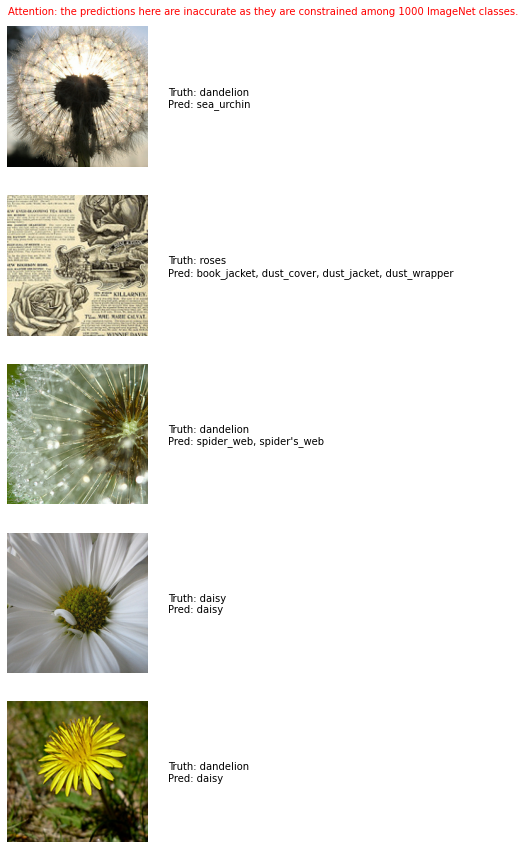

In [203]:
#@title Plot the images and predictions
fig, axes = plt.subplots(5, 1, figsize=(15, 15))
for i in range(5):
  axes[i].imshow(image[i])
  true_text = tf_flowers_labels[labels[i]]
  pred_text = imagenet_int_to_str[pred[i]]
  if i == 0:
    axes[i].text(0, 0, 'Attention: the predictions here are inaccurate as they are constrained among 1000 ImageNet classes.\n', c='r')
  axes[i].axis('off')
  axes[i].text(256, 128, 'Truth: ' + true_text + '\n' + 'Pred: ' + pred_text)

In [189]:
# aa = hub.Module(hub_path)

a = module(image)
logitss = tf.layers.dense(a, 1000)
prob = tf.nn.softmax(logitss)
a.shape

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


TensorShape([Dimension(5), Dimension(2048)])

In [166]:
from keras import layers
key['block_group4'].shape
print(np.min(sess.run(afaf)[2][:1000]))
print(np.min(sess.run(logits_t)))
print(len(module.variable_map))

model = tf.keras.Sequential([
  module(inputs=x['image'], signature="default"),
  layers.Dense(1000, activation='softmax')
])


0.0
-8.986575
281
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


TypeError: The added layer must be an instance of class Layer. Found: Tensor("module_apply_default_37/base_model/final_avg_pool:0", shape=(?, 2048), dtype=float32)

In [150]:
afaf = module(image)
print("names:", module.get_signature_names())
print("input:", module.get_input_info_dict())
print("output:", module.get_output_info_dict())
module.get_output_info_dict(), afaf.shape

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
names: ['default']
input: {'images': <hub.ParsedTensorInfo shape=(?, ?, ?, 3) dtype=float32 is_sparse=False>}
output: {'block_group2': <hub.ParsedTensorInfo shape=(?, ?, ?, 512) dtype=float32 is_sparse=False>, 'default': <hub.ParsedTensorInfo shape=(?, 2048) dtype=float32 is_sparse=False>, 'block_group4': <hub.ParsedTensorInfo shape=(?, ?, ?, 2048) dtype=float32 is_sparse=False>, 'block_group1': <hub.ParsedTensorInfo shape=(?, ?, ?, 256) dtype=float32 is_sparse=False>, 'final_avg_pool': <hub.ParsedTensorInfo shape=(?, 2048) dtype=float32 is_sparse=False>, 'logits_sup': <hub.ParsedTensorInfo shape=(?, 1000) dtype=float32 is_sparse=False>, 'initial_max_pool': <hub.ParsedTensorInfo shape=(?, ?, ?, 64) dtype=float32 is_sparse=False>, 'initial_conv': <hub.ParsedTensorInfo shape=(?, ?, ?, 64) dtype=float32 is_sparse=

({'block_group2': <hub.ParsedTensorInfo shape=(?, ?, ?, 512) dtype=float32 is_sparse=False>,
  'default': <hub.ParsedTensorInfo shape=(?, 2048) dtype=float32 is_sparse=False>,
  'block_group4': <hub.ParsedTensorInfo shape=(?, ?, ?, 2048) dtype=float32 is_sparse=False>,
  'block_group1': <hub.ParsedTensorInfo shape=(?, ?, ?, 256) dtype=float32 is_sparse=False>,
  'final_avg_pool': <hub.ParsedTensorInfo shape=(?, 2048) dtype=float32 is_sparse=False>,
  'logits_sup': <hub.ParsedTensorInfo shape=(?, 1000) dtype=float32 is_sparse=False>,
  'initial_max_pool': <hub.ParsedTensorInfo shape=(?, ?, ?, 64) dtype=float32 is_sparse=False>,
  'initial_conv': <hub.ParsedTensorInfo shape=(?, ?, ?, 64) dtype=float32 is_sparse=False>,
  'block_group3': <hub.ParsedTensorInfo shape=(?, ?, ?, 1024) dtype=float32 is_sparse=False>},
 TensorShape([Dimension(5), Dimension(2048)]))

In [26]:
afaf = module(image)
sess.run(afaf).shape
print(module.get_signature_names)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
<bound method Module.get_signature_names of <tensorflow_hub.module.Module object at 0x7f9877e65a10>>


In [6]:
# https://e3oroush.github.io/tsne-visualization/
import numpy as np
import tensorflow as tf
from PIL import Image
from sklearn.manifold import TSNE
import os, re, glob2, pickle

from keras.engine import  Model
from keras.layers import Input
# from keras_vggface.vggface import VGGFace
from keras.preprocessing import image
# from keras_vggface import utils

import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
# custom paramers: change these parameters to properly run on your machine
image_path = '/home/esoroush/Datasets/MSRC/MSRC/' # addres of images
no_of_images = 1600 # number of images. It is recommended to use a square of 2 number
ellipside =False # elipsoid or rectangular visualization
image_width = 64 # width and height of each visualized images
# choices are: inception, raw and vggfaces
feature_extraction = 'inception' # feature extraction method

In [ ]:
# find all images
image_names  = glob2.glob(image_path + "**/*.png") 
image_names +=glob2.glob(image_path + "**/*.jpg")
image_names +=glob2.glob(image_path + "**/*.gif")
# suffle images
np.random.seed(3)
np.random.shuffle(image_names)
if no_of_images > len(image_names):
    no_of_images = len(image_names)
image_names = image_names[:no_of_images]

In [ ]:
# Google inception pre-trained network
if feature_extraction == 'inception':
    print('using %s network/method for feature extraction'%feature_extraction)
    import sys, tarfile
    from six.moves import urllib
    model_dir = os.path.join(os.environ['HOME'], '.tensorflow/models')
    DATA_URL = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'
    def create_graph():

        """Creates a graph from saved GraphDef file and returns a saver."""
        # Creates graph from saved graph_def.pb.
        with tf.gfile.FastGFile(os.path.join(
          model_dir, 'classify_image_graph_def.pb'), 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
            _ = tf.import_graph_def(graph_def, name='')

    def run_inference_on_image(image):

        """Runs forward path on an image.
        Args:
        image: Image file name.

        Returns:
        off the shelf 2048 feature vector
        """
        if not tf.gfile.Exists(image):
            tf.logging.fatal('File does not exist %s', image)
        image_data = tf.gfile.FastGFile(image, 'rb').read()


        with tf.Session() as sess:
        # Some useful tensors:
        # 'softmax:0': A tensor containing the normalized prediction across
        #   1000 labels.
        # 'pool_3:0': A tensor containing the next-to-last layer containing 2048
        #   float description of the image.
        # 'DecodeJpeg/contents:0': A tensor containing a string providing JPEG
        #   encoding of the image.
        # Runs the softmax tensor by feeding the image_data as input to the graph.
            pool3 = sess.graph.get_tensor_by_name('pool_3:0')
            features = sess.run(pool3,
                                   {'DecodeJpeg/contents:0': image_data})
            return features
    
    def maybe_download_and_extract():
        """Download and extract model tar file."""
        dest_directory = model_dir
        if not os.path.exists(dest_directory):
            os.makedirs(dest_directory)
        filename = DATA_URL.split('/')[-1]
        filepath = os.path.join(dest_directory, filename)
        if not os.path.exists(filepath):
            def _progress(count, block_size, total_size):
                sys.stdout.write('\r>> Downloading %s %.1f%%' % ( 
                      filename, float(count * block_size) / float(total_size) * 100.0))
                sys.stdout.flush()
            filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)
            print()
            statinfo = os.stat(filepath)
            print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
        tarfile.open(filepath, 'r:gz').extractall(dest_directory)


    maybe_download_and_extract()
    # Creates graph from saved GraphDef.
    create_graph()
    feature_filename = '%s-feature-inception-%d.p'%(image_path.split('/')[-2], no_of_images)
    if os.path.exists(feature_filename):
        with open(feature_filename, 'rb') as f:
            features, image_names = pickle.load(f)
    else:
        features = np.zeros([no_of_images, 2048])
        for i in xrange(no_of_images):
            print('image name: %s index: %d/%d' %(image_names[i], i, no_of_images))
            features[i, :] = run_inference_on_image(image=image_names[i]).squeeze()
        with open(feature_filename, 'wb') as f:
            pickle.dump((features, image_names), f)

In [ ]:
# raw image pixels resized to 100x100
if feature_extraction == 'raw':
    print('using %s network/method for feature extraction'%feature_extraction)
    features = np.zeros([no_of_images, 100*100])
    for i, name in enumerate(image_names):
        features[i, :] = np.asarray(Image.open(name).resize((100, 100)).convert('L')).reshape(-1,)

In [ ]:
# vgg face pretrained network
if feature_extraction == 'vggfaces':
    print('using %s network/method for feature extraction'%feature_extraction)
    # Convolution Features
    features = np.zeros([no_of_images, 2048])
    vgg_model_conv = VGGFace(include_top=False, input_shape=(224, 224, 3), pooling='avg') # pooling: None, avg or max
    # FC7 Features
    vgg_model = VGGFace() # pooling: None, avg or max
    out = vgg_model.get_layer('fc7').output
    vgg_model_fc7 = Model(vgg_model.input, out)

    feature_filename = '%s-feature-vggfaces-%d.p'%(image_path.split('/')[-2], no_of_images)
    if os.path.exists(feature_filename):
        with open(feature_filename, 'rb') as f:
            features, image_names = pickle.load(f)
    else:
        features = np.zeros([no_of_images, 4096])
        for i, name in enumerate(image_names):
            img = image.load_img(name, target_size=(224, 224))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = utils.preprocess_input(x)
            print('image name: %s progress: %d/%d'%(name, i, no_of_images))
            features[i, :] = vgg_model_fc7.predict(x)
        with open(feature_filename, 'wb') as f:
            pickle.dump((features, image_names), f)

In [ ]:
# use tsne to cluster images in 2 dimensions
tsne = TSNE()
reduced = tsne.fit_transform(features)
reduced_transformed = reduced - np.min(reduced, axis=0)
reduced_transformed /= np.max(reduced_transformed, axis=0)
image_xindex_sorted = np.argsort(np.sum(reduced_transformed, axis=1))

In [ ]:
# draw all images in a merged image
merged_width = int(np.ceil(np.sqrt(no_of_images))*image_width)
merged_image = np.zeros((merged_width, merged_width, 3), dtype='uint8')

for counter, index in enumerate(image_xindex_sorted):
    # set location
    if ellipside:
        a = np.ceil(reduced_transformed[counter, 0] * (merged_width-image_width-1)+1)
        b = np.ceil(reduced_transformed[counter, 1] * (merged_width-image_width-1)+1)
        a = int(a - np.mod(a-1,image_width) + 1)
        b = int(b - np.mod(b-1,image_width) + 1)
        if merged_image[a,b,0] != 0:
            continue
        image_address = image_names[counter]
        img = np.asarray(Image.open(image_address).resize((image_width, image_width)))
        merged_image[a:a+image_width, b:b+image_width,:] = img[:,:,:3]
    else:
        b = int(np.mod(counter, np.sqrt(no_of_images)))
        a = int(np.mod(counter//np.sqrt(no_of_images), np.sqrt(no_of_images)))
        image_address = image_names[index]
        img = np.asarray(Image.open(image_address).resize((image_width, image_width)))
        merged_image[a*image_width:(a+1)*image_width, b*image_width:(b+1)*image_width,:] = img[:,:,:3]

plt.imshow(merged_image)
plt.show()
merged_image = Image.fromarray(merged_image)
if ellipside:
    merged_image.save('merged-%s-ellipsoide-inception.png'%image_path.split('/')[-2])
else:
    merged_image.save('merged-%s.png'%image_path.split('/')[-2])

In [20]:
a = np.array([[1,2], [2,6], [3,9], [9,3], [1,5]], dtype=float)
print(a)

normalized_a = a - np.min(a, axis=0)
normalized_a /= np.max(normalized_a, axis=0)
print(normalized_a)
# reduced_transformed = reduced - np.min(reduced, axis=0)
# reduced_transformed /= np.max(reduced_transformed, axis=0)
# image_xindex_sorted = np.argsort(np.sum(reduced_transformed, axis=1))

[[1. 2.]
 [2. 6.]
 [3. 9.]
 [9. 3.]
 [1. 5.]]
[[0.         0.        ]
 [0.125      0.57142857]
 [0.25       1.        ]
 [1.         0.14285714]
 [0.         0.42857143]]
